# **1. Dataset Exploration**

## 1.1 Combining both the dataset

The codes till data analysis was run locally because the datasets were huge and couldn't be uploades on drive

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import nibabel as nib

# -----------------------------
# Step 1: Set Up Paths and Parameters
# -----------------------------
dataset_dir = "E:/"
TR = 2.0  # Repetition time in seconds; adjust if needed

# List to hold event data rows
data_rows = []

# -----------------------------
# Step 2: Iterate Over Subject Folders and Extract fMRI Data and Event Timings
# -----------------------------
# Loop through all folders in dataset_dir that start with "sub-"
for subject in os.listdir(dataset_dir):
    if not subject.startswith("sub-"):
        continue
    subj_func_dir = os.path.join(dataset_dir, subject, "func")
    if not os.path.isdir(subj_func_dir):
        continue

    # Reading all events files in the subject's func folder
    event_files = [f for f in os.listdir(subj_func_dir) if f.endswith("_events.tsv")]

    for event_file in event_files:
        # Extracting the audio clip name from the filename
        match = re.search(r"task-([a-zA-Z0-9]+)_", event_file)
        if match:
            audio_clip = match.group(1)
        else:
            audio_clip = "unknown"

        events_path = os.path.join(subj_func_dir, event_file)
        # Constructing the corresponding fMRI BOLD filename
        fmri_filename = f"{subject}_task-{audio_clip}_bold.nii.gz"
        fmri_path = os.path.join(subj_func_dir, fmri_filename)

        # Proceed only if both the events and fMRI files exist
        if not os.path.exists(events_path) or not os.path.exists(fmri_path):
            continue

        print(f"Processing {subject} for audio clip '{audio_clip}'...")

        # Load the events file
        events_df = pd.read_csv(events_path, sep="\t")

        # Load the fMRI image using NiBabel
        fmri_img = nib.load(fmri_path)
        fmri_data = fmri_img.get_fdata()
        num_volumes = fmri_data.shape[-1]

        # Processing each event onset and duration in the events file
        for idx, row in events_df.iterrows():
            event_onset = row['onset']
            event_duration = row['duration']

            # Converting event onset and duration into fMRI volume indices using TR
            start_idx = int(round(event_onset / TR))
            end_idx = int(round((event_onset + event_duration) / TR))
            end_idx = min(end_idx, num_volumes)  # Ensuring we don't exceed available time points

            # Compute the scalar brain measure: mean activation over all voxels during the event
            if end_idx > start_idx:
                fmri_segment = fmri_data[..., start_idx:end_idx]  # 4D data for the event
                brain_measure = np.mean(fmri_segment)

                # Compute the high-dimensional brain vector:
                # Average over time to get a 3D volume, then flatten into a 1D vector.
                avg_volume = np.mean(fmri_segment, axis=-1)  # shape: (X, Y, Z)
                brain_vector = avg_volume.flatten()  # 1D vector
                # Convert the vector into a comma-separated string
                brain_vector_str = ",".join(map(str, brain_vector))
            else:
                brain_measure = np.nan
                brain_vector_str = ""

            # Append a row with subject, audio clip, event index, onset, duration, brain_measure, and brain_vector
            data_rows.append({
                "subject": subject,
                "audio_clip": audio_clip,
                "event_index": idx,
                "onset": event_onset,
                "duration": event_duration,
                "brain_measure": brain_measure,
                "brain_vector": brain_vector_str
            })

# -----------------------------
# Step 3: Saving the Results
# -----------------------------
df = pd.DataFrame(data_rows)
print("Created DataFrame with", len(df), "rows.")
print(df.head())


output_excel = os.path.join(dataset_dir, "brain_event_data.xlsx")
df.to_excel(output_excel, index=False)



## 1.2 Exploring DataSet

In [ ]:
import pandas as pd


df = pd.read_excel("brain_event_data.xlsx")
print("Shape:", df.shape)
print("Columns:\n", df.columns.tolist())
df.head()

Shape: (1034, 7)
Columns:
 ['subject', 'audio_clip', 'event_index', 'onset', 'duration', 'brain_measure', 'brain_vector']


,subject,audio_clip,event_index,onset,duration,brain_measure,brain_vector
0,sub-001,tunnel,0,3.0,1534,223.175686,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
1,sub-004,tunnel,0,3.0,1534,277.911410,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
2,sub-005,tunnel,0,3.0,1534,305.151879,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
3,sub-007,pieman,0,0.0,13,259.020827,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."
4,sub-007,pieman,1,15.0,422,259.312858,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."


In [ ]:
# we saw some inital zero values in the brain vector
#suggesting that some other of brain areas not involved in fmri were also recorded

In [ ]:

print(df.dtypes)

print("\nMissing values per column:\n", df.isnull().sum())

subject           object
audio_clip        object
event_index        int64
onset            float64
duration           int64
brain_measure    float64
brain_vector      object
dtype: object

Missing values per column:
 subject          0
audio_clip       0
event_index      0
onset            0
duration         0
brain_measure    0
brain_vector     0
dtype: int64


In [ ]:
import numpy as np

# Convert string to numeric brain vector
sample = df["brain_vector"].dropna().iloc[0]
brain_arr = np.array([float(x) for x in sample.split(",")])
print("Sample brain_vector length:", len(brain_arr))

Sample brain_vector length: 3146


In [ ]:
print("Unique subjects:", df["subject"].nunique())
print("Sample subjects:", df["subject"].unique()[:5])
print("Unique clips:", df["audio_clip"].unique())
print("Onset range:", df["onset"].min(), "-", df["onset"].max())
print("Duration range:", df["duration"].min(), "-", df["duration"].max())


Unique subjects: 260
Sample subjects: ['sub-001' 'sub-004' 'sub-005' 'sub-007' 'sub-009']
Unique clips: ['tunnel' 'pieman' 'notthefallintact' 'notthefallshortscram'
 'slumlordreach' 'lucy' 'milkyway' 'prettymouth' 'notthefalllongscram'
 'shapesphysical' 'shapessocial' '21styear' 'merlin' 'sherlock' 'black'
 'bronx' 'forgot' 'piemanpni']
Onset range: 0.0 - 969.5
Duration range: 13 - 3338


# **2. Speech-To-Text**

## 2.1 Saving Audio in GCS

In [ ]:
import os
import pandas as pd
from pydub import AudioSegment
from google.cloud import storage

# -----------------------------
# Step 1: Get the unique audio clips from the event files
# -----------------------------

event_excel = "E:/brain_event_data.xlsx"
df_events = pd.read_excel(event_excel)


# Getting unique audio clip names from the event data
unique_audio_clips = df_events['audio_clip'].unique()
print("Unique audio clips found:", unique_audio_clips)

# -----------------------------
# Step 2: Getting Audio Files from raw dataset
# -----------------------------

audio_dir = "E:/stimuli"

# Creating a folder for mono audio files within the stimuli folder
mono_local_dir = os.path.join(audio_dir, "mono")
os.makedirs(mono_local_dir, exist_ok=True)

# -----------------------------
# Step 3: Initialize Google Cloud Storage Client
# -----------------------------

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "" # Removed for security purpose
bucket_name = "neuroscience-audio-file"  # GCS Bucket where audio needs me saved

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)


gcs_folder = "mono" #folder in GCS bucket

# -----------------------------
# Step 4: Process Each Unique Audio Clip
# -----------------------------
results = []  # To store audio clip and its GCS URI

for clip in unique_audio_clips:
    # Constructing the filename for the original stereo audio.
    original_filename = f"{clip}_audio.wav"
    original_filepath = os.path.join(audio_dir, original_filename)

    if not os.path.exists(original_filepath):
        print(f"File not found: {original_filepath}")
        continue

    # Loading the original audio file using pydub
    audio = AudioSegment.from_file(original_filepath)

    # Converting to mono
    if audio.channels != 1:
        mono_audio = audio.set_channels(1)
        print(f"Converting {original_filename} to mono...")
    else:
        mono_audio = audio
        print(f"{original_filename} is already mono.")

    # Saving the mono audio file locally in the mono folder
    mono_filename = f"{clip}_audio_mono.wav"
    mono_filepath = os.path.join(mono_local_dir, mono_filename)
    mono_audio.export(mono_filepath, format="wav")

    # -----------------------------
    # Step 5: Upload the Mono Audio File to Google Cloud Storage
    # -----------------------------
    gcs_blob_name = f"{gcs_folder}/{mono_filename}"
    blob = bucket.blob(gcs_blob_name)
    blob.upload_from_filename(mono_filepath)
    print(f"Uploaded {mono_filename} to bucket '{bucket_name}' in folder '{gcs_folder}'.")

    # Construct the GCS URI
    gcs_uri = f"gs://{bucket_name}/{gcs_blob_name}"

    results.append({"audio_clip": clip, "gcs_uri": gcs_uri})

# -----------------------------
# Step 6: Saving the Audio URIs in an Excel File to parse it in LLM
# -----------------------------
results_df = pd.DataFrame(results)
output_excel = os.path.join(mono_local_dir, "audio_clip_gcs_uris.xlsx")
results_df.to_excel(output_excel, index=False)



## 2.2 SpeechtoText using google api

In [ ]:
import os
import time
import json
import wave
import pandas as pd
from pydub import AudioSegment
from google.cloud import speech_v1p1beta1 as speech

# -----------------------------
# Helper Function: Get Sample Rate from WAV File
# -----------------------------
def get_sample_rate(filepath):
    """Returns the sample rate of a WAV file."""
    with wave.open(filepath, "rb") as wf:
        return wf.getframerate()

# -----------------------------
# Step 1: Setup Unique Audio Clips and Paths
# -----------------------------
# Reading the URIs saved previously
df_uris = pd.read_excel("E:/audio_clip_gcs_uris.xlsx") # Manually Changed the path to the main directory


# Google Cloud Storage bucket details
bucket_name = "neuroscience-audio-file"
gcs_audio_folder = "mono"  # Folder in bucket where mono files are stored

# Local directories with original audio files
audio_dir = "E:/stimuli"
mono_local_dir = os.path.join(audio_dir, "mono")
os.makedirs(mono_local_dir, exist_ok=True)
output_transcript_folder = "E:/Audio text" # To store the transcripts
os.makedirs(output_transcript_folder, exist_ok=True)

# -----------------------------
# Step 2: Initialize Google Cloud Speech Client
# -----------------------------
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""  # Removed for security purposes
client = speech.SpeechClient()

# -----------------------------
# Step 3: Define Transcription Functions
# -----------------------------
def transcribe_audio_with_timestamps(gcs_uri, sample_rate, timeout=600):
    """
    Transcribes an audio file from a GCS URI using long-running recognition,
    using the provided sample rate.
    Returns the transcription response.
    """
    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=sample_rate,
        language_code="en-US",
        enable_word_time_offsets=True
    )
    operation = client.long_running_recognize(config=config, audio=audio)
    print(f"Transcribing {gcs_uri} with sample_rate_hertz={sample_rate}... ")
    response = operation.result(timeout=timeout)
    return response

def format_transcript(response):
    """
    Formats the transcription response into a text string with word-level timestamps.
    """
    transcript_text = ""
    for result in response.results:
        alternative = result.alternatives[0]
        transcript_text += f"Transcript: {alternative.transcript}\n"
        transcript_text += f"Confidence: {alternative.confidence}\n"
        transcript_text += "Word-level timestamps:\n"
        for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time.total_seconds()
            end_time = word_info.end_time.total_seconds()
            transcript_text += f"  Word: '{word}', start: {start_time}s, end: {end_time}s\n"
        transcript_text += "\n"
    return transcript_text

# -----------------------------
# Step 4: Process Each Unique Audio Clip: Check Sample Rate, Transcribe, and Save Results
# -----------------------------
audio_uri_results = []  # To store mapping of audio clip to GCS URI and sample rate

for i, row in df_uris.iterrows():
    clip = row['audio_clip']
    gcs_uri = row['gcs_uri']
    mono_filename = f"{clip}_audio_mono.wav"
    mono_filepath = os.path.join(mono_local_dir, mono_filename)

    # Step 4a: Getting the sample rate for this audio file.
    try:
        sample_rate = get_sample_rate(mono_filepath)
        print(f"Sample rate for {mono_filename}: {sample_rate} Hz")
    except Exception as e:
        print(f"Error reading sample rate for {mono_filename}: {e}")
        continue


    # Transcribe the audio file using the detected sample rate.
    try:
        response = transcribe_audio_with_timestamps(gcs_uri, sample_rate)
        transcript_str = format_transcript(response)

        # Saving the transcript to a text file
        output_filename = f"{clip}_transcript.txt"
        output_path = os.path.join(output_transcript_folder, output_filename)
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(transcript_str)
        print(f"Transcript for '{clip}' saved to {output_path}")

        # Save the mapping
        audio_uri_results.append({"audio_clip": clip, "gcs_uri": gcs_uri, "sample_rate": sample_rate})
    except Exception as e:
        print(f"Error processing {clip}: {e}")

# -----------------------------
# Step 5: REplacing same excel with Audio URI Mapping
# -----------------------------
if audio_uri_results:
    df_audio_uris = pd.DataFrame(audio_uri_results)
    output_mapping_excel = os.path.join(output_transcript_folder, "audio_clip_gcs_uris.xlsx")
    df_audio_uris.to_excel(output_mapping_excel, index=False)
    print("Audio clip URI mapping saved to:", output_mapping_excel)
else:
    print("No audio URI mappings to save.")



# LLM Use

In [ ]:
import os
import re
import json
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2Model

# -----------------------------
# Helper Function: Parse Transcript File
# -----------------------------
def parse_transcript(file_path):
    """
    Parses a transcript text file with lines formatted like:
      Word: '', start: ...s, end: ...s
    Returns a list of dictionaries with keys: 'word', 'start', and 'end'.
    """
    words = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith("Word:"):
                match = re.search(r"Word:\s*'(.+?)',\s*start:\s*([\d\.]+)s,\s*end:\s*([\d\.]+)s", line)
                if match:
                    word = match.group(1)
                    start = float(match.group(2))
                    end = float(match.group(3))
                    words.append({'word': word, 'start': start, 'end': end})
    return words

# -----------------------------
# Helper Function: Extract Event Text
# -----------------------------
def extract_event_text(transcript_words, onset, duration):
    """
    Returns the concatenated text for words in transcript_words whose timestamps
    fall within the window [onset, onset + duration].
    """
    event_words = [w['word'] for w in transcript_words if w['start'] >= onset and w['end'] <= (onset + duration)]
    return " ".join(event_words)

# -----------------------------
# Helper Function: Get Averaged LLM Representations
# -----------------------------
def get_llm_avg(text, tokenizer, model, max_length=512):
    """
    Processes the text through GPT-2 and returns a list of averaged hidden state vectors for each layer.
    If text is empty, returns a list of NaN vectors (each of length 768).
    """
    num_layers = 13  # Embedding layer + 12 transformer layers
    if text.strip() == "":
        return [[np.nan]*768 for _ in range(num_layers)]

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of length 13, each of shape (1, seq_len, 768)
    avg_vectors = []
    for layer in hidden_states:
        avg_vec = layer.mean(dim=1).squeeze().cpu().numpy().tolist()
        avg_vectors.append(avg_vec)
    return avg_vectors

# -----------------------------
# Step 1: Loading Brain Event Data Excel
# -----------------------------
brain_excel_path = "E:/brain_event_data.xlsx"
df_brain = pd.read_excel(brain_excel_path)

# -----------------------------
# Step 2: Setting Up Transcript Folder and Initialize GPT-2
# -----------------------------
transcript_folder = "E:/Audio text"
transcript_cache = {}  # To avoid reloading the same transcript multiple times

# Initialize GPT-2 tokenizer and model (we only need hidden states, not attentions)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)

# -----------------------------
# Step 3: Adding New Columns for LLM Data in DF
# -----------------------------
num_layers = 13
for i in range(num_layers):
    df_brain[f"LLM_layer_{i}_avg"] = ""
df_brain["event_text_extracted"] = ""

# -----------------------------
# Step 4: Processing Each Brain Event audio clip to Get LLM Data for the specific duration
# -----------------------------
for idx, row in df_brain.iterrows():
    clip = row['audio_clip']
    onset = row['onset']
    duration = row['duration']

    # Load transcript for this audio clip, using cache to avoid reloading
    transcript_file = os.path.join(transcript_folder, f"{clip}_transcript.txt")
    if clip not in transcript_cache:
        if os.path.exists(transcript_file):
            transcript_words = parse_transcript(transcript_file)
            transcript_cache[clip] = transcript_words
        else:
            print(f"Transcript file for {clip} not found at {transcript_file}.")
            transcript_cache[clip] = []
    else:
        transcript_words = transcript_cache[clip]

    # Extract event text based on the event's onset and duration.
    event_text = extract_event_text(transcript_words, onset, duration)
    df_brain.at[idx, "event_text_extracted"] = event_text

    # Process the event text through GPT-2 to obtain averaged hidden states for each layer.
    llm_avg_vectors = get_llm_avg(event_text, tokenizer, model)
    for i in range(num_layers):
        # Converting the averaged vector (list of floats) to a JSON string for storage.
        avg_str = json.dumps(llm_avg_vectors[i])
        df_brain.at[idx, f"LLM_layer_{i}_avg"] = avg_str

    if (idx+1) % 100 == 0:
        print(f"Processed {idx+1} events.")

# -----------------------------
# Step 5: Save Combined Data to a Excel File
# -----------------------------
output_excel_path = "E:/brain_event_data_with_llm_avg.xlsx"
df_brain.to_excel(output_excel_path, index=False)


# Brain masking and final file

In [ ]:
import os
import re
import pandas as pd
import nibabel as nib
import numpy as np

# -----------------------------
# Step 1: Load Brain Event Data and Get Unique Subjects
# -----------------------------

Brain_Event_data = "E:/brain_event_data_with_llm_avg.xlsx"
df = pd.read_excel(Brain_Event_data)
print("Loaded cleaned data with", len(df), "rows.")


unique_subjects = df['subject'].unique()
print("Unique subjects found:", unique_subjects)

# -----------------------------
# Step 2: Base Directory and Parameters
# -----------------------------
dataset_dir = "E:"
threshold_fraction = 0.1  # Using 10% of the max intensity as threshold for the mask

# -----------------------------
# Step 3: Brain Mask for each subject
# -----------------------------
for subject in unique_subjects:
    anat_dir = os.path.join(dataset_dir, subject, "anat")
    if not os.path.isdir(anat_dir):
        print(f"Subject {subject}: 'anat' folder not found. Skipping.")
        continue

    # Checking if a brain mask already exists
    existing_masks = [f for f in os.listdir(anat_dir)
                      if "brainmask" in f.lower() and f.endswith((".nii", ".nii.gz"))]
    if existing_masks:
        print(f"Subject {subject}: Brain mask already exists ({existing_masks[0]}). Skipping.")
        continue

    # Looking for the T1w anatomical image in the anat folder
    t1w_files = [f for f in os.listdir(anat_dir) if "T1w" in f and f.endswith((".nii", ".nii.gz"))]
    if not t1w_files:
        print(f"Subject {subject}: No T1w file found in {anat_dir}. Skipping.")
        continue

    t1w_path = os.path.join(anat_dir, t1w_files[0])
    try:
        t1w_img = nib.load(t1w_path)
        t1w_data = t1w_img.get_fdata()
    except Exception as e:
        print(f"Subject {subject}: Error loading T1w file {t1w_path}: {e}. Skipping.")
        continue

    # Compute threshold: 10% of the maximum intensity
    threshold = threshold_fraction * np.max(t1w_data)
    brain_mask = t1w_data > threshold
    print(f"Subject {subject}: Generated brain mask using threshold {threshold:.2f} with shape {brain_mask.shape}.")

    # Saving the mask as a new NIfTI file in the same anat folder.
    mask_img = nib.Nifti1Image(brain_mask.astype(np.uint8), t1w_img.affine, t1w_img.header)
    mask_save_path = os.path.join(anat_dir, f"{subject}_brainmask.nii.gz")
    try:
        nib.save(mask_img, mask_save_path)
        print(f"Subject {subject}: Saved brain mask to {mask_save_path}.")
    except Exception as e:
        print(f"Subject {subject}: Error saving brain mask: {e}.")

print("Brain mask generation complete.")

# Final Data Analysis File
# -----------------------------
# Step 1: Set Paths and Load Brain Event Data
# -----------------------------
dataset_dir = "E:"
# Path to the cleaned brain event data Excel file
brain_event_excel = os.path.join(dataset_dir, "brain_event_data_with_llm_avg.xlsx")

df_events = pd.read_excel(brain_event_excel)

# -----------------------------
# Step 2: Extracting Unique Subjects from the Event Data
# -----------------------------
unique_subjects = df_events["subject"].unique()
print("Unique subjects in event data:", unique_subjects)

# -----------------------------
# Step 3: For Each Subject, Load the Brain Mask and Compute Summary Details
# -----------------------------
mask_details_list = []

for subj in unique_subjects:
    anat_dir = os.path.join(dataset_dir, subj, "anat")
    mask_filename = f"{subj}_brainmask.nii.gz"
    mask_path = os.path.join(anat_dir, mask_filename)

    if not os.path.exists(mask_path):
        print(f"Subject {subj}: Brain mask not found at {mask_path}.")
        continue

    try:
        mask_img = nib.load(mask_path)
        mask_data = mask_img.get_fdata()
        mask_binary = mask_data > 0
        # Computing summary details
        num_brain_voxels = int(np.sum(mask_binary))
        total_voxels = np.prod(mask_binary.shape)
        percentage = 100 * num_brain_voxels / total_voxels
    except Exception as e:
        print(f"Subject {subj}: Error loading mask {mask_path}: {e}")
        continue

    mask_details_list.append({
        "subject": subj,
        "mask_path": mask_path,
        "mask_shape": str(mask_binary.shape),
        "num_brain_voxels": num_brain_voxels,
        "total_voxels": total_voxels,
        "percentage_brain": percentage
    })
    print(f"Subject {subj}: Mask summary - {num_brain_voxels} brain voxels out of {total_voxels} ({percentage:.2f}%).")


df_masks = pd.DataFrame(mask_details_list)


# -----------------------------
# Step 4: Merging Brain Event Data with Mask Details
# -----------------------------
# Merge on the subject column. This will add the mask details to every event row for that subject.
df_merged = pd.merge(df_events, df_masks, on="subject", how="left")
# Check a few rows:
print(df_merged.head())

# -----------------------------
# Step 5: Saving the Combined Data to a New Excel File
# -----------------------------
output_excel_path = os.path.join(dataset_dir, "Data_analysis.xlsx")
df_merged.to_excel(output_excel_path, index=False)




# Data Analysis

## RidgeRegressionCV and RSA

Loaded data with 581 rows.
Columns in data: ['subject', 'audio_clip', 'event_index', 'onset', 'duration', 'brain_measure', 'brain_vector', 'LLM_layer_0_avg', 'LLM_layer_1_avg', 'LLM_layer_2_avg', 'LLM_layer_3_avg', 'LLM_layer_4_avg', 'LLM_layer_5_avg', 'LLM_layer_6_avg', 'LLM_layer_7_avg', 'LLM_layer_8_avg', 'LLM_layer_9_avg', 'LLM_layer_10_avg', 'LLM_layer_11_avg', 'LLM_layer_12_avg', 'event_text_extracted', 'mask_path', 'mask_shape', 'num_brain_voxels', 'total_voxels', 'percentage_brain']

Event distribution by subject:
subject
sub-111    8
sub-106    8
sub-084    8
sub-139    7
sub-065    7
          ..
sub-259    1
sub-255    1
sub-260    1
sub-261    1
sub-271    1
Name: count, Length: 243, dtype: int64

Detected 285 events that appear to overlap in time (rough check).

Filtering out overlapping events based on config...
Removed 237 overlapping events. Remaining: 344

After filtering subjects with >= 1 events, 344 rows remain.

Found 344 valid brain vectors out of 344 rows after f

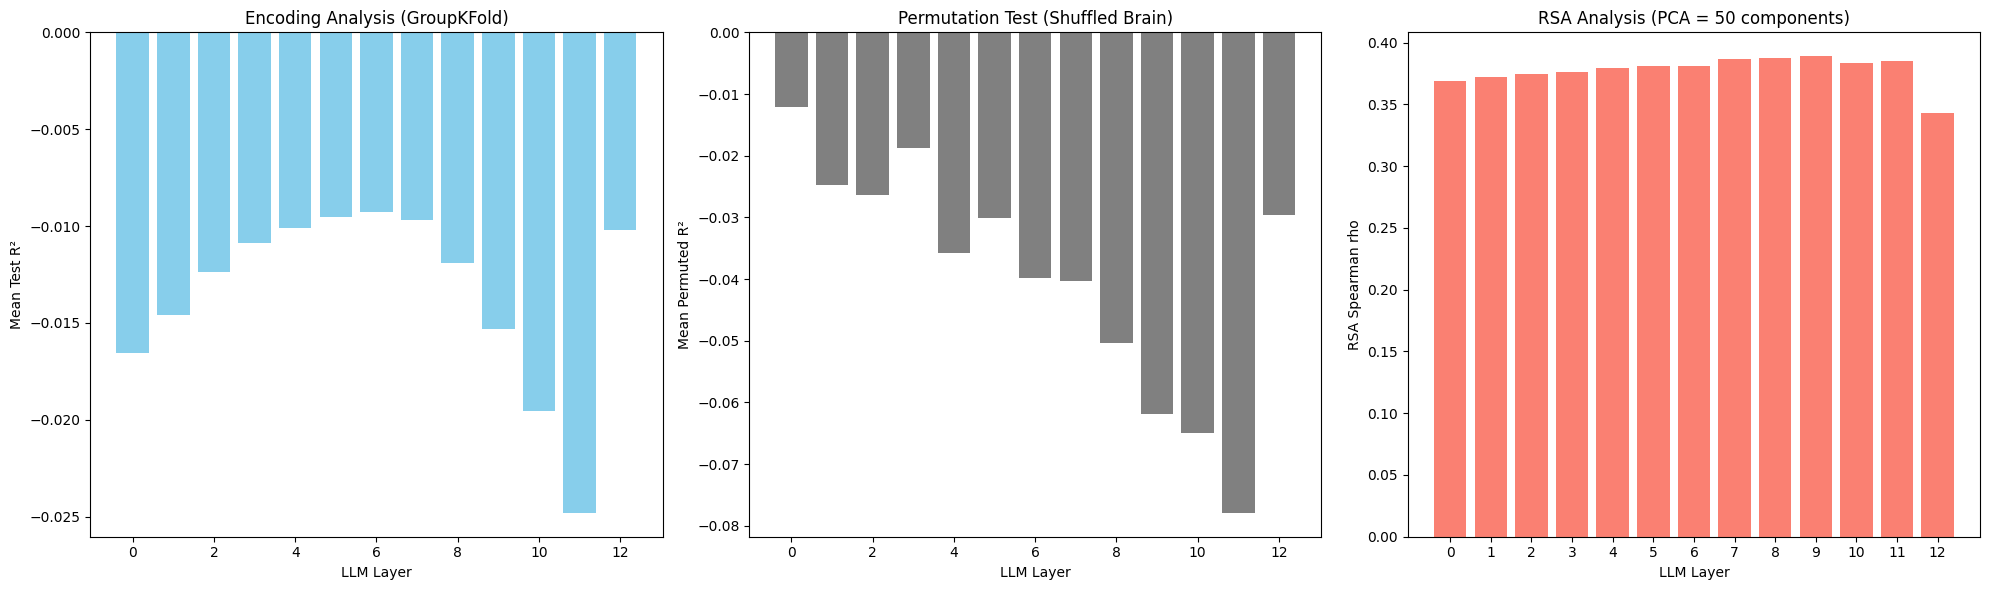


All analyses complete!


In [ ]:
import os
import pandas as pd
import numpy as np
import json
import math
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# -----------------------------
# Configuration Parameters
# -----------------------------
DATA_EXCEL_PATH = "Data_analysis.xlsx"
MIN_EVENTS_PER_SUBJECT = 1    # Allowing subjects with at least 1 event
REMOVE_ALL_OVERLAPS = False   # Relax filtering: do not remove all overlaps
MAX_OVERLAP_RATIO = 0.70      # Removing event if it overlaps >70% with a previously kept event
N_PCA_COMPONENTS = 50         # Using 50 PCA components
USE_GROUPKFOLD = True         # Using GroupKFold
N_GROUPKFOLD_SPLITS = 2       # Using 2 splits for GroupKFold (less stringent)

# -----------------------------
# Helper Functions
# -----------------------------
def parse_and_trim_vector(s, threshold=1e-7):
    """
    Parses a comma-separated string into a numpy array and removes leading near-zero values.
    Returns the trimmed array or None if invalid.
    """
    try:
        s = s.strip()
        vec = np.array([float(x) for x in s.split(",") if x.strip() != ""])
        if vec.size == 0:
            return None
        nonzero_indices = np.where(np.abs(vec) > threshold)[0]
        if nonzero_indices.size == 0:
            return None
        first_nonzero = nonzero_indices[0]
        return vec[first_nonzero:]
    except:
        return None

def parse_llm_vector(s, expected_dim=768):
    """
    Parses an LLM averaged representation from a string into a numpy array of dimension expected_dim.
    Returns None if invalid.
    """
    try:
        s = s.strip()
        if s.startswith("[") and s.endswith("]"):
            arr = np.array(json.loads(s))
        else:
            arr = np.array([float(x) for x in s.split(",") if x.strip() != ""])
        if arr.size != expected_dim:
            return None
        return arr
    except:
        return None

def compute_rdm(matrix):
    """
    Computes the Representational Dissimilarity Matrix (RDM) using correlation distance (1 - Pearson correlation).
    Returns the square RDM.
    """
    dists = pdist(matrix, metric='correlation')
    return squareform(dists)

def filter_overlapping_events(df):
    """
    Filters overlapping events per subject.
    If REMOVE_ALL_OVERLAPS is False, only events with an overlap ratio > MAX_OVERLAP_RATIO are removed.
    """
    df_sorted = df.sort_values(by=["subject", "onset"])
    filtered_rows = []
    for subj, group in df_sorted.groupby("subject"):
        keep_indices = []
        kept_events = []  # List of (start, end) for events kept
        for idx, row in group.iterrows():
            start, dur = row['onset'], row['duration']
            end = start + dur
            overlap_found = False
            for (k_start, k_end) in kept_events:
                overlap_start = max(start, k_start)
                overlap_end   = min(end, k_end)
                overlap_duration = max(0, overlap_end - overlap_start)
                if dur > 0:
                    overlap_ratio = overlap_duration / dur
                else:
                    overlap_ratio = 0
                if REMOVE_ALL_OVERLAPS:
                    if overlap_duration > 0:
                        overlap_found = True
                        break
                else:
                    if overlap_ratio > MAX_OVERLAP_RATIO:
                        overlap_found = True
                        break
            if not overlap_found:
                keep_indices.append(idx)
                kept_events.append((start, end))
        filtered_rows.append(group.loc[keep_indices])
    return pd.concat(filtered_rows, axis=0).sort_index()

def reduce_brain_vectors_pca(brain_matrix, n_components=N_PCA_COMPONENTS):
    """
    Applies PCA to the brain_matrix and returns the transformed data (n_events x n_components).
    """
    pca = PCA(n_components=n_components)
    return pca.fit_transform(brain_matrix)

# -----------------------------
# Main Analysis Code
# -----------------------------
def main():
    df = pd.read_excel(DATA_EXCEL_PATH)
    print(f"Loaded data with {len(df)} rows.")
    print("Columns in data:", df.columns.tolist())

    print("\nEvent distribution by subject:")
    print(df["subject"].value_counts())

    # Rough overlap check
    df_sorted = df.sort_values(by=["subject", "onset"])
    overlap_count = 0
    for subj, group in df_sorted.groupby("subject"):
        prev_end = -1
        for _, row in group.iterrows():
            start, dur = row['onset'], row['duration']
            end = start + dur
            if start < prev_end:
                overlap_count += 1
            prev_end = max(prev_end, end)
    print(f"\nDetected {overlap_count} events that appear to overlap in time (rough check).")

    # Filter out overlapping events based on config
    print("\nFiltering out overlapping events based on config...")
    before_overlap = len(df)
    df = filter_overlapping_events(df)
    after_overlap = len(df)
    print(f"Removed {before_overlap - after_overlap} overlapping events. Remaining: {after_overlap}")

    # Filter out subjects with fewer than MIN_EVENTS_PER_SUBJECT events (relaxed)
    subj_counts = df["subject"].value_counts()
    valid_subjs = subj_counts[subj_counts >= MIN_EVENTS_PER_SUBJECT].index
    df = df[df["subject"].isin(valid_subjs)].reset_index(drop=True)
    print(f"\nAfter filtering subjects with >= {MIN_EVENTS_PER_SUBJECT} events, {len(df)} rows remain.")

    # Parse and trim brain vectors using the new trimming function
    df["parsed_brain_vector"] = df["brain_vector"].apply(lambda s: parse_and_trim_vector(s))
    df["llm_parsed"] = df["LLM_layer_8_avg"].apply(lambda s: parse_llm_vector(s, expected_dim=768))
    df = df.dropna(subset=["parsed_brain_vector", "llm_parsed"])
    valid_brain = df["parsed_brain_vector"].dropna()
    print(f"\nFound {len(valid_brain)} valid brain vectors out of {len(df)} rows after filtering.")
    if len(valid_brain) == 0:
        raise ValueError("No valid brain vectors could be parsed. Exiting.")

    min_length = min(vec.size for vec in valid_brain)
    print("Minimum brain vector length across valid rows:", min_length)

    df["trimmed_brain_vector"] = df["parsed_brain_vector"].apply(
        lambda vec: vec[:min_length] if vec is not None and vec.size >= min_length else None
    )
    df = df[df["trimmed_brain_vector"].notnull()].reset_index(drop=True)

    brain_matrix = np.vstack(df["trimmed_brain_vector"])
    print("Brain matrix shape after trimming:", brain_matrix.shape)

    # Applying PCA to reduce dimensionality
    print(f"\nApplying PCA to reduce brain vectors to {N_PCA_COMPONENTS} components...")
    brain_matrix_pca = reduce_brain_vectors_pca(brain_matrix, n_components=N_PCA_COMPONENTS)
    print("Brain matrix (PCA) shape:", brain_matrix_pca.shape)

    # -----------------------------
    # Multi-Layer Analysis (Encoding, Permutation Test, RSA)
    # -----------------------------
    num_layers = 13
    encoding_scores = []         # Mean test R² per layer
    encoding_scores_shuffled = []  # Mean permuted R² per layer
    rsa_scores = []              # RSA Spearman rho per layer
    rsa_pvals = []               # RSA p-values per layer

    expected_llm_dim = 768
    def parse_llm_avg(s):
        return parse_llm_vector(s, expected_llm_dim)

    # Use GroupKFold with N_GROUPKFOLD_SPLITS splits
    from sklearn.model_selection import GroupKFold
    cv_obj = GroupKFold(n_splits=N_GROUPKFOLD_SPLITS)
    groups = df["subject"].values

    for layer in range(num_layers):
        llm_col = f"LLM_layer_{layer}_avg"
        df[f"parsed_{llm_col}"] = df[llm_col].apply(lambda s: parse_llm_avg(s))
        valid_mask = df[f"parsed_{llm_col}"].notnull()
        valid_llm = df[f"parsed_{llm_col}"][valid_mask]
        print(f"\n--- LLM Layer {layer} ---")
        print(f"Found {len(valid_llm)} valid LLM vectors out of {len(df)} rows.")
        if len(valid_llm) == 0:
            encoding_scores.append(np.nan)
            encoding_scores_shuffled.append(np.nan)
            rsa_scores.append(np.nan)
            rsa_pvals.append(np.nan)
            continue

        try:
            llm_matrix = np.vstack(valid_llm)
        except Exception as e:
            print(f"Layer {layer}: Error stacking LLM data: {e}")
            encoding_scores.append(np.nan)
            encoding_scores_shuffled.append(np.nan)
            rsa_scores.append(np.nan)
            rsa_pvals.append(np.nan)
            continue

        valid_indices = valid_llm.index.tolist()
        brain_mat_layer = brain_matrix_pca[valid_indices, :]
        subj_valid = df.loc[valid_indices, "subject"].values

        print(f"LLM matrix shape: {llm_matrix.shape}, Brain matrix (PCA) shape: {brain_mat_layer.shape}")

        # --- Encoding Analysis ---
        cv_scores = []
        for train_idx, test_idx in cv_obj.split(llm_matrix, groups=subj_valid):
            if len(test_idx) < 2:
                continue
            X_train, X_test = llm_matrix[train_idx], llm_matrix[test_idx]
            y_train, y_test = brain_mat_layer[train_idx], brain_mat_layer[test_idx]
            model = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = r2_score(y_test, y_pred)
            cv_scores.append(score)
        mean_r2 = np.mean(cv_scores) if len(cv_scores) > 0 else np.nan
        encoding_scores.append(mean_r2)
        print(f"Mean Encoding R² = {mean_r2:.3f}")

        # --- Permutation Test: Shuffle Brain Data ---
        cv_scores_perm = []
        shuffled_brain = brain_mat_layer.copy()
        np.random.shuffle(shuffled_brain)
        for train_idx, test_idx in cv_obj.split(llm_matrix, groups=subj_valid):
            if len(test_idx) < 2:
                continue
            X_train, X_test = llm_matrix[train_idx], llm_matrix[test_idx]
            y_train, y_test = shuffled_brain[train_idx], shuffled_brain[test_idx]
            model_perm = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5)
            model_perm.fit(X_train, y_train)
            y_pred_perm = model_perm.predict(X_test)
            score_perm = r2_score(y_test, y_pred_perm)
            cv_scores_perm.append(score_perm)
        mean_r2_perm = np.mean(cv_scores_perm) if len(cv_scores_perm) > 0 else np.nan
        encoding_scores_shuffled.append(mean_r2_perm)
        print(f"Mean Encoding R² (Permuted) = {mean_r2_perm:.3f}")

        # --- RSA Analysis ---
        try:
            brain_rdm = compute_rdm(brain_mat_layer)
            llm_rdm = compute_rdm(llm_matrix)
            triu_idx = np.triu_indices_from(brain_rdm, k=1)
            brain_vec = brain_rdm[triu_idx]
            llm_vec = llm_rdm[triu_idx]
            rho, p_val = spearmanr(brain_vec, llm_vec)
        except Exception as e:
            print(f"Layer {layer}: RSA computation error: {e}")
            rho, p_val = np.nan, np.nan
        rsa_scores.append(rho)
        rsa_pvals.append(p_val)
        print(f"RSA Spearman rho = {rho:.3f}, p-value = {p_val:.3e}")

    # --- Plotting Results ---
    layers = list(range(num_layers))
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))

    ax[0].bar(layers, encoding_scores, color='skyblue')
    ax[0].set_xlabel("LLM Layer")
    ax[0].set_ylabel("Mean Test R²")
    cv_type = "GroupKFold" if USE_GROUPKFOLD else "LOSO"
    ax[0].set_title(f"Encoding Analysis ({cv_type})")

    ax[1].bar(layers, encoding_scores_shuffled, color='gray')
    ax[1].set_xlabel("LLM Layer")
    ax[1].set_ylabel("Mean Permuted R²")
    ax[1].set_title("Permutation Test (Shuffled Brain)")

    ax[2].bar(layers, rsa_scores, color='salmon')
    ax[2].set_xlabel("LLM Layer")
    ax[2].set_ylabel("RSA Spearman rho")
    ax[2].set_title(f"RSA Analysis (PCA = {N_PCA_COMPONENTS} components)")
    plt.xticks(layers)
    plt.tight_layout()
    plt.show()

    print("\nAll analyses complete!")

if __name__ == "__main__":
    main()


Did encoding (PCA = 50) and nomalization and then used RidgCV (skit-learning regressor but no linear relationship found)
`




## Ridge Regression with Hyperparameter Tuning (GridSearchCV)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import r2_score
import json
from sklearn.decomposition import PCA

df = pd.read_excel("Data_analysis.xlsx")

# Parse and trim brain vectors
def parse_and_trim_vector(s, threshold=1e-7):
    try:
        vec = np.array([float(x) for x in s.strip().split(",") if x.strip()])
        nonz = np.where(np.abs(vec) > threshold)[0]
        return vec[nonz[0]:] if nonz.size > 0 else None
    except:
        return None

def parse_llm_vector(s, expected_dim=768):
    try:
        if not isinstance(s, str): return None
        arr = json.loads(s) if s.strip().startswith("[") else [float(x) for x in s.split(",")]
        return np.array(arr) if len(arr) == expected_dim else None
    except:
        return None

df["brain_vector_parsed"] = df["brain_vector"].apply(parse_and_trim_vector)
min_len = min(len(v) for v in df["brain_vector_parsed"] if v is not None)
df["brain_trimmed"] = df["brain_vector_parsed"].apply(lambda v: v[:min_len] if v is not None and len(v) >= min_len else None)
df = df[df["brain_trimmed"].notnull()].reset_index(drop=True)

X_brain = np.vstack(df["brain_trimmed"])
print("Brain matrix shape:", X_brain.shape)

pca = PCA(n_components=50)
X_brain_pca = pca.fit_transform(X_brain)

# Group labels
groups = df["subject"].values

# Loop through each LLM layer
from tqdm import tqdm
results = []

for layer in tqdm(range(13), desc="Ridge tuning for each LLM layer"):
    col = f"LLM_layer_{layer}_avg"
    df[f"llm_{layer}"] = df[col].apply(parse_llm_vector)
    df_valid = df[df[f"llm_{layer}"].notnull()].copy()

    if len(df_valid) < 10:
        results.append((layer, np.nan, np.nan))
        continue

    X = np.vstack(df_valid[f"llm_{layer}"])
    y = X_brain_pca[df_valid.index]

    param_grid = {
        "alpha": np.logspace(-4, 4, 20)
    }

    ridge = Ridge()
    gkf = GroupKFold(n_splits=2)
    grid = GridSearchCV(ridge, param_grid, cv=gkf.split(X, y, groups=df_valid["subject"].values), scoring="r2")
    grid.fit(X, y)

    best_r2 = grid.best_score_
    best_alpha = grid.best_params_["alpha"]
    results.append((layer, best_r2, best_alpha))
    print(f"Layer {layer}: Best R² = {best_r2:.4f}, Alpha = {best_alpha}")



Brain matrix shape: (581, 520)


Ridge tuning for each LLM layer:   8%|▊         | 1/13 [00:02<00:31,  2.61s/it]

Layer 0: Best R² = -0.0024, Alpha = 1.623776739188721


Ridge tuning for each LLM layer:  15%|█▌        | 2/13 [00:05<00:31,  2.87s/it]

Layer 1: Best R² = -0.0023, Alpha = 545.5594781168514


Ridge tuning for each LLM layer:  23%|██▎       | 3/13 [00:07<00:25,  2.54s/it]

Layer 2: Best R² = -0.0013, Alpha = 545.5594781168514


Ridge tuning for each LLM layer:  31%|███       | 4/13 [00:10<00:23,  2.60s/it]

Layer 3: Best R² = -0.0012, Alpha = 545.5594781168514


Ridge tuning for each LLM layer:  38%|███▊      | 5/13 [00:15<00:28,  3.55s/it]

Layer 4: Best R² = -0.0011, Alpha = 1438.44988828766


Ridge tuning for each LLM layer:  46%|████▌     | 6/13 [00:18<00:23,  3.29s/it]

Layer 5: Best R² = -0.0008, Alpha = 1438.44988828766


Ridge tuning for each LLM layer:  54%|█████▍    | 7/13 [00:22<00:20,  3.38s/it]

Layer 6: Best R² = -0.0005, Alpha = 1438.44988828766


Ridge tuning for each LLM layer:  62%|██████▏   | 8/13 [00:27<00:19,  3.96s/it]

Layer 7: Best R² = -0.0004, Alpha = 3792.690190732246


Ridge tuning for each LLM layer:  69%|██████▉   | 9/13 [00:29<00:13,  3.50s/it]

Layer 8: Best R² = -0.0002, Alpha = 3792.690190732246


Ridge tuning for each LLM layer:  77%|███████▋  | 10/13 [00:32<00:09,  3.14s/it]

Layer 9: Best R² = -0.0011, Alpha = 10000.0


Ridge tuning for each LLM layer:  85%|████████▍ | 11/13 [00:34<00:05,  2.88s/it]

Layer 10: Best R² = -0.0013, Alpha = 10000.0


Ridge tuning for each LLM layer:  92%|█████████▏| 12/13 [00:37<00:02,  2.89s/it]

Layer 11: Best R² = -0.0030, Alpha = 10000.0


Ridge tuning for each LLM layer: 100%|██████████| 13/13 [00:42<00:00,  3.25s/it]

Layer 12: Best R² = -0.0091, Alpha = 545.5594781168514


Still got negative R Sq. Tried to find Non-linear relation

## MLP for non-linear relationship

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 1: Prepare Data
# -----------------------------
df = pd.read_excel("Data_analysis.xlsx")

def parse_brain_vector(s, threshold=1e-7):
    arr = np.array([float(x) for x in s.split(",") if x.strip()])
    nonz = np.where(np.abs(arr) > threshold)[0]
    if nonz.size == 0: return None
    return arr[nonz[0]:]

def parse_llm_vector(s, dim=768):
    if not isinstance(s, str): return None
    arr = np.array(json.loads(s)) if s.strip().startswith("[") else np.array([float(x) for x in s.split(",")])
    return arr if arr.size == dim else None

df["brain_arr"] = df["brain_vector"].apply(parse_brain_vector)
df["llm9_arr"] = df["LLM_layer_9_avg"].apply(parse_llm_vector)

df = df[df["brain_arr"].notnull() & df["llm9_arr"].notnull()].reset_index(drop=True)

# Align all vectors to same size
min_len = min(len(v) for v in df["brain_arr"])
df["brain_trim"] = df["brain_arr"].apply(lambda v: v[:min_len])

X = np.vstack(df["llm9_arr"])
Y = np.vstack(df["brain_trim"])

# -----------------------------
# Step 2: Split and Define Model
# -----------------------------
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

mlp = MLPRegressor(max_iter=500)

param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(mlp, param_grid, cv=3, scoring='r2', verbose=1)
grid.fit(X_train, Y_train)

best_model = grid.best_estimator_
print("Best Hyperparameters:", grid.best_params_)

# -----------------------------
# Step 3: Evaluate
# -----------------------------
Y_pred = best_model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}
MAE: 1.1959
MSE: 2.8649
RMSE: 1.6926
R²: 0.9061
